## Notebook Description

## Required Libraries

In [1]:
# Data Manipulation
import numpy as np
import pandas as pd

import json

# Visualizations
import matplotlib.pyplot as plt

# Operating System
import os

# Model Development

from sklearn.model_selection import StratifiedKFold

# Convenience
from tqdm import tqdm

# Bias Detection
from medicalbiasdetection import utils


# Notebook Operating Conditions
pd.set_option('display.max_rows', 250)
pd.set_option('display.max_columns', 250)
import warnings
warnings.filterwarnings("ignore")

config = utils.read_yaml()

# Global Variables
RUN = 3
RANDOM_STATE = 0


LOG_DIR = config['LOG']['dir'].format(RUN=RUN)
LOG_PATH = config['LOG']['path'].format(RUN=RUN)
os.environ['LOG_PATH'] = LOG_PATH
os.environ['RUN'] = str(RUN)

from medicalbiasdetection import model as md
from medicalbiasdetection import cohort
from medicalbiasdetection import process

## Load Reference Data

In [2]:
# identify the medical facility for the dataset
med_fac = 'grady' # 'grady' # 'emory'
X = cohort.load_reference_data(med_fac,config, verbose=True)

Number of encounters (csn): 119733
Years: [2016 2017 2018 2019 2020]
Start year: 2016
End year: 2020
Number of unique patient visits: 119733
Number of unique patients: 73484
Number of sepsis=0 patients: 101269 (84.58%)
Number of sepsis=1 patients: 18464 (15.42%)


## Update Reference Data

In [3]:
X = cohort.update_cohort(X, verbose=True)
cohort.print_cohort_report(X,'csn','pat_id','sepsis')

Total CSNs included: 15163
Removed CSNs:
step           reason                          
preprocessing  non-ICU patient                     101935
               less than 24 hours of icu data        2616
               corrupted file - did not process        16
               gender unknown                           3
dtype: int64
Number of encounters (csn): 15163
Years: [2016 2017 2018 2019 2020]
Start year: 2016
End year: 2020
Number of unique patient visits: 15163
Number of unique patients: 13899
Number of sepsis=1 patients: 6658 (43.91%)
Number of sepsis=0 patients: 8505 (56.09%)


## Load Hourly Data

In [4]:
df = cohort.load_hourly_data(config)

100%|██████████| 6/6 [03:29<00:00, 34.87s/it]


## Right-Censor Data

In [7]:
run_cell = True
if run_cell:
    sepsis_col = "sepsis_lag_6"

    sep_counts = df[sepsis_col].value_counts()
    n = df.shape[0]
    sep_counts_norm = df[sepsis_col].value_counts(normalize=True)
    print(f"Patient Hours before censoring: {df.shape[0]}")
    print(f"Non-sepsis hours = {sep_counts[0]} ({np.round(sep_counts_norm[0],2)*100}%)")
    print(f"Sepsis hours = {sep_counts[1]} ({np.round(sep_counts_norm[1],2)*100}%)")
    print("#"*50)

    df = cohort.right_censor(df,sepsis_col)

    sep_counts = df[sepsis_col].value_counts()
    sep_counts_norm = df[sepsis_col].value_counts(normalize=True)
    print(f"Patient Hours after censoring: {df.shape[0]}")
    print(f"Non-sepsis hours = {sep_counts[0]} ({np.round(sep_counts_norm[0],3)*100}%)")
    print(f"Sepsis hours = {sep_counts[1]} ({np.round(sep_counts_norm[1],3)*100}%)")

    print("#"*50)
    print(f"Removed {n - df.shape[0]} hours. {np.round(1-(df.shape[0]/n),2)*100}% Reduction")

Patient Hours before censoring: 2103683
Non-sepsis hours = 1255008 (60.0%)
Sepsis hours = 848675 (40.0%)
##################################################
Patient Hours after censoring: 1261262
Non-sepsis hours = 1255008 (99.5%)
Sepsis hours = 6254 (0.5%)
##################################################
Removed 842421 hours. 40.0% Reduction


## Train, Test, Validation Sets
- This is a two part train/test/validation split
- The first split will be temporally based with patients admitted before 2018 comprising the training and validation sets
  and patients after 2018 making up the test set
- The second split for the training and validation data will be based on each patients information.
- The first 24 hours of patient data will be used in the training set
- Remaining hours following the first 24 will be used for the test set with a maximum number of hours available being 168 (7 days)

## Temporal Splits

In [8]:
print("Temporal Split Report")
print("#"*50)
print("Training  & Validation")
cohort.print_cohort_report(X[X['year']<=2018],'csn','pat_id','sepsis')
print("#"*50)
print("Testing")
cohort.print_cohort_report(X[X['year']>2018],'csn','pat_id','sepsis')

Temporal Split Report
##################################################
Training  & Validation
Number of encounters (csn): 9310
Years: [2016 2017 2018]
Start year: 2016
End year: 2018
Number of unique patient visits: 9310
Number of unique patients: 8683
Number of sepsis=1 patients: 4141 (44.48%)
Number of sepsis=0 patients: 5169 (55.52%)
##################################################
Testing
Number of encounters (csn): 5853
Years: [2019 2020]
Start year: 2019
End year: 2020
Number of unique patient visits: 5853
Number of unique patients: 5486
Number of sepsis=1 patients: 2517 (43.00%)
Number of sepsis=0 patients: 3336 (57.00%)


In [9]:
run_cell = True
if run_cell:
    
    # Perform temporal splits
    X_train = X[X['year']<=2018]
    X_test = X[X['year']>2018]
    y_train = X_train['sepsis']
    y_test = X_test['sepsis']
    
    
    # get patient csns for training data
    csns_train = X_train.csn.unique().tolist()
    print(f"Number of patients in training set: {len(csns_train)}")
    cohort.print_cohort_report(X_train,'csn','pat_id','sepsis')

    # get patient csns for test data
    csns_test = X_test.csn.unique().tolist()
    print(f"Number of patients in test set: {len(csns_test)}")
    cohort.print_cohort_report(X_test,'csn','pat_id','sepsis')
    
    # Initialize Stratified K-Folds
    stkf = StratifiedKFold(n_splits=5)
    
    # Initialize arrays to collect training and validation sets
    train_sets = []
    val_sets = []
    ks = []

    # Perform StratifiedKFold on the combined dataset and store results
    for k, (train_idx, val_idx) in enumerate(stkf.split(X_train, y_train)):
        train_sets.append(X_train.iloc[train_idx])
        val_sets.append(X_train.iloc[val_idx])
        ks.append(k)


    # set parameters for time series split
    train_hours = 24 # 1 day
    max_hours = 168 # 7 days
    y = 'sepsis_lag_6'
    
    # set the save path
    path = config['DIR']['train_test_split'].format(RUN=RUN)
    
    # for each k-fold 
    for k in tqdm(ks):
        # get train csns
        train_csn_k = train_sets[k]['csn'].unique().tolist()

        # create temp training data df
        train_df_k = df[df['csn'].isin(train_csn_k)]

        # initialize arrays to store training and validation data
        X_train_list, y_train_list, X_val_list, y_val_list = [], [], [], []

       
        # for each patient in the training data
        for csn in train_csn_k:    
            # create temp df
            pat_df = train_df_k[train_df_k['csn']==csn]
            
            # perform time series split to create training and validation sets
            X_train_k, y_train_k, X_val_k, y_val_k = md.timeseries_train_test_split(pat_df, y, train_hours, max_hours)
            
            # append training and validation data
            X_train_list.append(X_train_k)
            y_train_list.append(y_train_k)
            X_val_list.append(X_val_k)
            y_val_list.append(y_val_k)

        # Concatenate results
        X_train_df = pd.concat(X_train_list, axis=0)
        y_train_df = pd.concat(y_train_list, axis=0)
        X_val_df = pd.concat(X_val_list, axis=0)
        y_val_df = pd.concat(y_val_list, axis=0)

        # save datasets
        filepath = f"{path}X_train_{k}.csv"
        X_train_df.to_csv(filepath, mode='a', header=not os.path.exists(filepath))

        filepath = f"{path}y_train_{k}.csv"
        y_train_df.to_csv(filepath,mode='a', header=not os.path.exists(filepath))

        filepath = f"{path}X_val_{k}.csv"
        X_val_df.to_csv(filepath,mode='a', header=not os.path.exists(filepath))

        filepath = f"{path}y_val_{k}.csv"
        y_val_df.to_csv(filepath,mode='a', header=not os.path.exists(filepath))



    # create test data
    test_data = df[df['csn'].isin(csns_test)]
    X_test_df = test_data
    y_test_df = test_data[y]

    # save test data
    filepath = f"{path}X_test.csv"
    X_test_df.to_csv(filepath,mode='a', header=not os.path.exists(filepath))

    filepath = f"{path}y_test.csv"
    y_test_df.to_csv(filepath,mode='a', header=not os.path.exists(filepath))

Number of patients in training set: 9310
Number of encounters (csn): 9310
Years: [2016 2017 2018]
Start year: 2016
End year: 2018
Number of unique patient visits: 9310
Number of unique patients: 8683
Number of sepsis=1 patients: 4141 (44.48%)
Number of sepsis=0 patients: 5169 (55.52%)
Number of patients in test set: 5853
Number of encounters (csn): 5853
Years: [2019 2020]
Start year: 2019
End year: 2020
Number of unique patient visits: 5853
Number of unique patients: 5486
Number of sepsis=1 patients: 2517 (43.00%)
Number of sepsis=0 patients: 3336 (57.00%)


100%|██████████| 5/5 [14:23<00:00, 172.79s/it]


## Load Training, Validation, and Test Data

In [2]:
# read files from the current run
path = config['DIR']['train_test_split'].format(RUN=RUN)

# set prefix for csv files
prefix = "X_train"

# get the count of the files
k = utils.get_max_index(path,prefix) + 1

# get columns to drop
drop_cols = config['model']['drop_cols']

# create data dictionary to collect each fold
data_dict = {}

for i in tqdm(range(k),leave=True):
    sub_dict={}
    sub_dict['X_train'] = pd.read_csv(f"{path}/X_train_{i}.csv",index_col = [0]).drop(columns=drop_cols,errors='ignore')
    sub_dict['y_train'] = pd.read_csv(f"{path}/y_train_{i}.csv",index_col = [0])
    sub_dict['X_val'] = pd.read_csv(f"{path}/X_val_{i}.csv",index_col = [0]).drop(columns=drop_cols,errors='ignore')
    sub_dict['y_val'] = pd.read_csv(f"{path}/y_val_{i}.csv",index_col = [0])
    data_dict[i] = sub_dict
    
data_dict['X_test'] = pd.read_csv(f"{path}/X_test.csv",index_col = [0])
data_dict['y_test'] = pd.read_csv(f"{path}/y_test.csv",index_col = [0])

100%|██████████| 5/5 [01:10<00:00, 14.10s/it]


## ID and save positive cases

In [11]:
# create cases filename
filename = config['DIR']['cases'].format(RUN=RUN)

# identify cases
cases = data_dict['X_test'].groupby('csn')['sepsis_lag_6'].sum()

# save
pd.DataFrame(cases[cases > 0]).reset_index().to_csv(filename)

## Model Training

In [4]:
run_cell = True
if run_cell:
    # Suppress specific warning from xgboost
    warnings.filterwarnings("ignore", message="ntree_limit is deprecated, use `iteration_range` or model slicing instead.")
    # select loss function
    loss_functions = ['Accuracy','F1_Score','F2_Score'] #'Accuracy','F1_Score','F2_Score'

    for loss_function_name in loss_functions:
        print(f"Training Models using {loss_function_name}")

        model_path = config['DIR']['models'].format(RUN=RUN,OBJECTIVE=loss_function_name)
        if not os.path.exists(model_path):
            os.mkdir(model_path)
            print(f"Created {loss_function_name} Directory")

        for i in range(k):

            # set training data
            X = data_dict[i]['X_train'].replace({np.inf:np.nan, -np.inf:np.nan})
            
            X['y'] = data_dict[i]['y_train']

            # downsample the training data
            X = md.downsample(X,'y')

            # assign X & y train values
            y_train = X['y'].values
            X_train = X.drop(columns=['y'],errors='ignore').values

            print(f"Training Data Shape: {np.shape(X_train)}")
            print(f"Number of positive sepsis hours: {sum(y_train)}")
            print("\n")

            # set validation data
            X_val = data_dict[i]['X_val'].replace({np.inf:np.nan, -np.inf:np.nan}).drop(columns=['y'],errors='ignore')
           
            X_val = X_val.values
            
            y_val = data_dict[i]['y_val'].values

            print(f"Validation Data Shape: {np.shape(X_val)}")
            print(f"Number of positive sepsis hours: {sum(y_val)}")

            md.train_model(i, X_train, y_train, X_val, y_val, loss_function_name, save_model_dir=model_path)
    

Training Models using Accuracy
Training Data Shape: (5038, 210)
Number of positive sepsis hours: 2519.0


Validation Data Shape: (511893, 210)
Number of positive sepsis hours: [560.]
Loss function being used: Accuracy
*************************************************************
1th training ..............
Hyperparameters optimization
100%|██████████| 20/20 [03:42<00:00, 11.14s/trial, best loss: 0.0011564916886928067]
obtained best_param
training dataset AUC: 0.9697082640373021
training dataset acc: 0.945017864231838
training dataset f2-score: 0.9309405543983336
validation dataset AUC: 0.7709895019488278
validation dataset acc: 0.998904067842303
validation dataset f2-score: 0.0
************************************************************
Training Data Shape: (5166, 210)
Number of positive sepsis hours: 2583.0


Validation Data Shape: (507410, 210)
Number of positive sepsis hours: [515.]
Loss function being used: Accuracy
*************************************************************
2th

## Run Model: Test Data

In [5]:
run_cell = True
right_censor_predictions = True
if run_cell:
    # identify columns to drop
    drop_cols = config['model']['drop_cols'] + ['y']

    # set validation data
    X_test = data_dict['X_test'].replace({np.inf:np.nan, -np.inf:np.nan})
    X_test['y'] = data_dict['y_test'].astype(int)

    # get patient csns in test set
    test_set = X_test['csn'].unique().tolist()

    # array of loss function types 
    loss_functions = ['Accuracy','F1_Score','F2_Score']  #'Accuracy','F1_Score',,'ROC_AUC_Score'

    # set prediction threshold
    prediction_thresh = 0.50
    
        
    # for each loss function-based model
    for loss_function_name in tqdm(loss_functions, leave=True): 
        
        # set path to model directory
        model_dir = config['DIR']['models'].format(RUN=RUN,OBJECTIVE=loss_function_name)

        # get the number of k_folds
        k_folds = utils.get_max_index(model_dir,'model')
        
        # set save path name for test predictions
        TYPE = 'hourly'
        prediction_dir = config['DIR']['predictions'].format(RUN=RUN, OBJECTIVE = loss_function_name, TYPE=TYPE)
        if not os.path.exists(prediction_dir):
            os.mkdir(prediction_dir)
        outpath = os.path.join(prediction_dir,f'prediction_results_test_{TYPE}.csv')

        # make predictions on test set
        predictions = md.predict(test_set, X_test, model_dir, k_folds, outpath, prediction_thresh, drop_cols)
        
        # right censor predictions
        if right_censor_predictions:
            predictions = cohort.right_censor(predictions, 'y_true')
            # save updated predictions
            predictions.to_csv(outpath)
        # set save path for summarized prediction results
        TYPE = 'summary'
        prediction_dir = config['DIR']['predictions'].format(RUN=RUN, OBJECTIVE = loss_function_name, TYPE=TYPE)
        outpath = os.path.join(prediction_dir,f'prediction_results_test_{TYPE}.csv')
        if not os.path.exists(prediction_dir):
            os.mkdir(prediction_dir)
            
        # summarize test prediction results
        test_results = md.summarize_predictions(predictions,'y_true','y_prob',prediction_thresh)
        
        # save test data 
        test_results.to_csv(outpath, index=False)


100%|██████████| 3/3 [38:53<00:00, 777.71s/it]


## Run Model: Training Data

In [19]:
run_cell= False
right_censor_predictions = True
if run_cell:
    X = cohort.load_reference_data('grady', config, verbose=True)
    X = cohort.update_cohort(X, verbose=True)
    df = cohort.load_hourly_data(config)
    
    # identify columns to drop
    drop_cols = config['model']['drop_cols'] + ['y']

    # identify y column name
    y_column = 'sepsis_lag_6'

    # create data set
    train_csns = X[X['year']<=2018]['csn'].unique().tolist()
    X = df[df['csn'].isin(train_csns)].copy()
    X['y'] = X[y_column]
    
    print('Data Loaded')

    # array of loss function types 
    loss_functions = ['Accuracy','F1_Score','F2_Score'] #'Accuracy','F1_Score','F2_Score','ROC_AUC_Score'

    # set prediction threshold
    prediction_thresh = 0.50

    # for each loss function-based model
    for loss_function_name in tqdm(loss_functions, leave=True): 
        # set path to model directory
        model_dir = config['DIR']['models'].format(RUN=RUN,OBJECTIVE=loss_function_name)

        # get the number of k_folds
        k_folds = utils.get_max_index(model_dir,'model')

        # set save path name for test predictions
        TYPE = 'hourly'
        prediction_dir = config['DIR']['predictions'].format(RUN=RUN, OBJECTIVE = loss_function_name, TYPE=TYPE)
        outpath = os.path.join(prediction_dir,f'prediction_results_training_{TYPE}.csv')

        # make predictions on training set
        predictions = md.predict(train_csns, X, model_dir, k_folds, outpath, prediction_thresh, drop_cols)
        
        # right censor predictions
        if right_censor_predictions:
            predictions = cohort.right_censor(predictions, 'y_true')
            # save updated predictions
            predictions.to_csv(outpath)
            
        # set save path for summarized prediction results
        TYPE = 'summary'
        prediction_dir = config['DIR']['predictions'].format(RUN=RUN, OBJECTIVE = loss_function_name, TYPE=TYPE)
        outpath = os.path.join(prediction_dir,f'prediction_results_training_{TYPE}.csv')

        # summarize test prediction results
        results = md.summarize_predictions(predictions,'y_true','y_prob',prediction_thresh)

        # save test data 
        results.to_csv(outpath, index=False)


## Run Model: All Data

In [18]:
run_cell= False

if run_cell:
    X = cohort.load_reference_data('grady', config, verbose=True)
    X = cohort.update_cohort(X, verbose=True)
    
    # identify columns to drop
    drop_cols = config['meta']['drop_cols']

    # identify y column name
    y_column = 'sepsis_lag_6'

    # create data set
    X = df.copy()
    X['y'] = X[y_column]

    print('Data Loaded')

    # array of loss function types 
    loss_functions = ['Accuracy','F1_Score','F2_Score'] #'Accuracy','F1_Score','F2_Score','ROC_AUC_Score'

    # set prediction threshold
    prediction_thresh = 0.50

    # for each loss function-based model
    for loss_function_name in tqdm(loss_functions, leave=True): 
        # set path to model directory
        model_dir = config['DIR']['models'].format(RUN=RUN,OBJECTIVE=loss_function_name)

        # get the number of k_folds
        k_folds = utils.get_max_index(model_dir,'model')

        # set save path name for test predictions
        TYPE = 'hourly'
        prediction_dir = config['DIR']['predictions'].format(RUN=RUN, OBJECTIVE = loss_function_name, TYPE=TYPE)
        outpath = os.path.join(prediction_dir,f'prediction_results_training_{TYPE}.csv')

        # make predictions on training set
        predictions = md.predict(all_csns, X, model_dir, k_folds, outpath, prediction_thresh, drop_cols)

        # remove data past 168 hour period
        predictions['hour'] = predictions.index
        predictions['hour'] = predictions['hour'].apply(lambda x: int(x.split('_')[1]))

        # set save path for summarized prediction results
        TYPE = 'summary'
        prediction_dir = config['DIR']['predictions'].format(RUN=RUN, OBJECTIVE = loss_function_name, TYPE=TYPE)
        outpath = os.path.join(prediction_dir,f'prediction_results_training_{TYPE}.csv')

        # summarize test prediction results
        results = md.summarize_predictions(predictions,'y_true','y_prob',prediction_thresh)

        # save test data 
        results.to_csv(outpath, index=False)


## Test for Individual Models

In [4]:
run_cell = True
right_censor_predictions = False

if run_cell:
    # identify columns to drop
    drop_cols = config['model']['drop_cols']+['y']

    # set validation data
    X_test = data_dict['X_test'].replace({np.inf:np.nan, -np.inf:np.nan})
    X_test['y'] = data_dict['y_test'].astype(int)

    # get patient csns in test set
    test_set = X_test['csn'].unique().tolist()

    # array of loss function types 
    loss_functions = ['Accuracy','F1_Score','F2_Score']  #,'F1_Score','Accuracy',,'ROC_AUC_Score'

    # set prediction threshold
    prediction_thresh = 0.50

    
    # for each loss function-based model
    for loss_function_name in tqdm(loss_functions, leave=True): 
        # set path to model directory
        model_dir = config['DIR']['models'].format(RUN=RUN,OBJECTIVE=loss_function_name)

        # get the number of k_folds
        k_folds = utils.get_max_index(model_dir,'model')
        
        # set save path name for test predictions
        TYPE = 'hourly'
        prediction_dir = config['DIR']['predictions'].format(RUN=RUN, OBJECTIVE = loss_function_name, TYPE=TYPE)
        if not os.path.exists(prediction_dir):
            os.mkdir(prediction_dir)
        outpath = os.path.join(prediction_dir,f'prediction_results_test_i_models.csv')

        # make predictions on test set
        predictions = md.predict_i(test_set, X_test, model_dir, k_folds, outpath, prediction_thresh, drop_cols)
        # right censor predictions
        if right_censor_predictions:
            predictions = cohort.right_censor(predictions, 'y_true')
            # save updated predictions
            # predictions.to_csv(outpath)
        # add ensemeble predictions
        prob_cols = [x for x in predictions.columns if "prob_" in x]
        predictions['ensemble_prob'] = predictions[prob_cols].mean(axis=1)
        predictions['ensemble_label'] = np.where(predictions['ensemble_prob']<prediction_thresh,0,1)

        # save predictions
        predictions.to_csv(outpath)

100%|██████████| 3/3 [11:18<00:00, 226.15s/it]


## Load Individual Model Performance Metrics

In [5]:
OBJECTIVE = "F2_Score"
TYPE = 'hourly'
prediction_dir = config['DIR']['predictions'].format(RUN=RUN, OBJECTIVE = OBJECTIVE, TYPE=TYPE)
path = os.path.join(prediction_dir,f'prediction_results_test_i_models.csv')
predictions = pd.read_csv(path, index_col=0)


## Summarize Individual and Ensemble Model Performance

In [6]:
k_folds = 5
prediction_thresh = 0.5
model_predictions = []
for i in range(k_folds):
    i = i+1
    model_i_metrics = md.summarize_predictions_i(predictions,'y_true',f'prob_{i}',prediction_thresh)
    model_i_metrics['model'] = i
    model_i_metrics['thresh'] = prediction_thresh
    model_predictions.append(model_i_metrics)

model_pred_df = pd.concat(model_predictions,axis=0)

ens_pred = md.summarize_predictions_i(predictions,'y_true',f'ensemble_prob',prediction_thresh)
ens_pred['model'] = 'ensemble'
ens_pred['thresh'] = prediction_thresh
model_pred_df = pd.concat([model_pred_df,ens_pred], axis=0)
display(model_pred_df[['model','accuracy','roc_auc','f2_score']])
model_pred_df[['model','accuracy','roc_auc','f2_score']].mean(axis=0)


,model,accuracy,roc_auc,f2_score
0,1,0.988424,0.903147,0.589141
0,2,0.990231,0.900930,0.617701
0,3,0.991099,0.901991,0.635113
0,4,0.990730,0.899722,0.625486
0,5,0.987234,0.899840,0.566766
0,ensemble,0.992073,0.901855,0.654187


accuracy    0.989965
roc_auc     0.901247
f2_score    0.614732
dtype: float64

## Visualize MCC Performance Across Prediction Thresholds

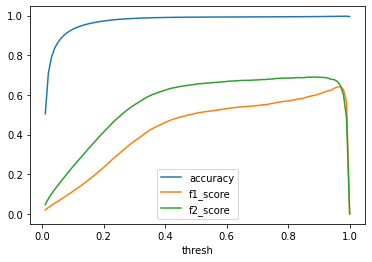

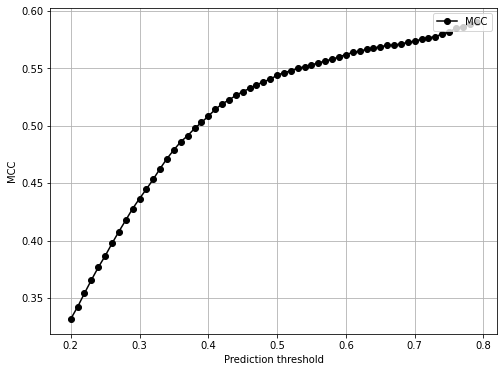

In [7]:
# init results list
ens_results = []
# iterate through all possible prediction thresholds
for i in range(1,101):
    i/=100
    ens_pred_i = md.summarize_predictions_i(predictions,'y_true',f'ensemble_prob',i)
    ens_pred_i["thresh"] = i
    ens_results.append(ens_pred_i)
ens_df = pd.concat(ens_results, axis=0)

ens_df.plot(x="thresh",y=["accuracy","f1_score","f2_score"])
# isolate a range of thresholds
rt = ens_df[(ens_df['thresh']>=0.2)&(ens_df['thresh']<0.8)]

# Create the line plot
plt.figure(figsize=(8, 6))
y_axis = "mcc"
plt.plot(rt['thresh'], rt[y_axis], marker='o', color='black', label='MCC')  # 'o' creates the circular markers

# Labeling the axes
plt.xlabel('Prediction threshold')
plt.ylabel(f'MCC')
plt.legend(loc='upper right')

# Show the grid
plt.grid(True)

# save the plot
save_path = f"MBD_Runs/{RUN}/images/MCC.png"
# plt.savefig(save_path, dpi=600)
# Display the plot
plt.show()

